In [232]:
import os; os.chdir('/Users/joncon/Sites/magd_client/')
from magD.pickle import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
##some constants for all plots
lat_min=43.0
lat_max=51.5
lon_min=-130.0
lon_max=-115.0
resolution=0.1
num_solutions=4



### Action Window for offshore event

In [367]:
offshore_lat=48
offshore_lon=-125

#contour around event
%run -i scripts/make_grids.py \
--name=offshore \
--grid_types=dist_max \
--lat_min=$lat_min \
--lat_max=$lat_max \
--lon_min=$lon_min \
--lon_max=$lon_max \
--resolution=$resolution \
--num_solutions=$num_solutions

Profiling spatially...
Created the following grids:
/Users/joncon/Sites/magd_client/scripts/../pickle_jar/offshore/dist_max_grid/85x150-res-0.1.pickle


In [368]:
#contour offshore event
grid_offshore_event_path = "./pickle_jar/offshore/dist_max_grid/85x150-res-0.1.pickle"
grid_offshore_event = get_pickle(grid_offshore_event_path)

In [369]:
#create a single origin, then find nth closest current station distance
%run -i scripts/make_grids.py \
--name=washington_current \
--grid_types=dist_max \
--lat_min=$offshore_lat \
--lat_max=$offshore_lat  \
--lon_min=$offshore_lon  \
--lon_max=$offshore_lon \
--resolution=0.1 \
--num_solutions=$num_solutions

Profiling spatially...
Created the following grids:
/Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current/dist_max_grid/1x1-res-0.1.pickle


In [370]:
#distnace from event to 4th current station. matrix is 1x1
distance_offshore_path = "./pickle_jar/washington_current/dist_max_grid/1x1-res-0.1.pickle"
distance_offshore = get_pickle(distance_offshore_path)

In [371]:
#create a single origin, then find nth closest station distance
%run -i scripts/make_grids.py \
--name=washington_current_and_notional \
--grid_types=dist_max \
--lat_min=$offshore_lat \
--lat_max=$offshore_lat  \
--lon_min=$offshore_lon  \
--lon_max=$offshore_lon \
--resolution=0.1 \
--num_solutions=$num_solutions

Profiling spatially...
Created the following grids:
/Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current_and_notional/dist_max_grid/1x1-res-0.1.pickle


In [372]:
distance_offshore_n_path = "./pickle_jar/washington_current_and_notional/dist_max_grid/1x1-res-0.1.pickle"
distance_offshore_n = get_pickle(distance_offshore_n_path)

In [373]:
velocity_p = 5.4
velocity_s = 3
processing_time = 4

##############################################################
#offshore event
###############################################################
offshore_depth = 20

print("Distance to 4th station with current stations:")
print(distance_offshore.matrix[0][0])

print("Distance to 4th station with current and notional stations:")
print(distance_offshore_n.matrix[0][0])

station_markers = distance_offshore.markers


#from distance path, find trigger time. Use this time for every point in eq contour map
travel_current=distance_offshore.copy("travel_time", "offshore20")
travel_current.transform_to_trigger_time(velocity_p, processing_time, offshore_depth)
travel_current.save()

#trigger time (seconds)
trigger_time= travel_current.matrix[0][0]
print("offshore trigger time")
print(trigger_time)

#subtract contour grid from this value
grid_offshore_alert = grid_offshore_event.copy("event_warning", "offshore20")
grid_offshore_alert.markers =  {**station_markers, **grid_offshore_alert.markers}
grid_offshore_alert.firstn_solutions =distance_offshore.firstn_solutions
grid_offshore_alert.transform_to_s_travel_time(velocity_s, offshore_depth)
grid_offshore_alert.matrix =  grid_offshore_alert.matrix -trigger_time 
grid_offshore_alert.matrix.clip(0)
grid_offshore_alert.save()
grid_offshore_alert_path = grid_offshore_alert.get_path()


#distance from event to 4th current notional station. matrix is 1x1


station_n_markers = distance_offshore_n.markers

#from distance path, find trigger time. Use this time for every point in eq contour map
travel_notional=distance_offshore_n.copy("travel_time", "offshore_n20")
travel_notional.transform_to_trigger_time(velocity_p, processing_time, offshore_depth)
travel_notional.save()

#trigger time (seconds)
trigger_time_n = travel_notional.matrix[0][0]
print("offshore trigger time")
print(trigger_time_n)
delta_trigger = (trigger_time - trigger_time_n).round(2)
print("delta trigger time:")
print(delta_trigger)
delta_string= "Notional Improvement: {}".format(delta_trigger) 

#subtract contour grid from this value
grid_offshore_n_alert = grid_offshore_event.copy("event_warning", "offshore20_notional")
grid_offshore_n_alert.markers =  {**station_n_markers, **grid_offshore_n_alert.markers}
grid_offshore_n_alert.firstn_solutions = distance_offshore_n.firstn_solutions
grid_offshore_n_alert.transform_to_s_travel_time(velocity_s, offshore_depth)
grid_offshore_n_alert.matrix =  grid_offshore_n_alert.matrix -trigger_time_n 
grid_offshore_n_alert.matrix.clip(0)
grid_offshore_n_alert.save()
grid_offshore_n_alert_path = grid_offshore_n_alert.get_path()

#diff the two

grid_diff_offshore_alert = grid_offshore_n_alert.copy("event_warning_diff", "diff_offshore20")
print(grid_offshore_n_alert.matrix[0][0:5])
print(grid_offshore_alert.matrix[0][0:5])
grid_diff_offshore_alert.matrix =  grid_offshore_n_alert.matrix.clip(0) - grid_offshore_alert.matrix.clip(0)
print(grid_diff_offshore_alert.matrix[0][0:5])

# grid_diff_offshore_alert.matrix.clip(0)
grid_diff_offshore_alert.save()
grid_diff_offshore_alert_path = grid_diff_offshore_alert.get_path()

Distance to 4th station with current stations:
67.1797465573
Distance to 4th station with current and notional stations:
42.9855724319
offshore trigger time
16.980303676
offshore trigger time
12.7797298917
delta trigger time:
4.2
[ 213.52374979  212.04745055  210.5914752   209.15622603  207.74210998]
[ 209.323176    207.84687677  206.39090142  204.95565225  203.54153619]
[ 4.20057378  4.20057378  4.20057378  4.20057378  4.20057378]


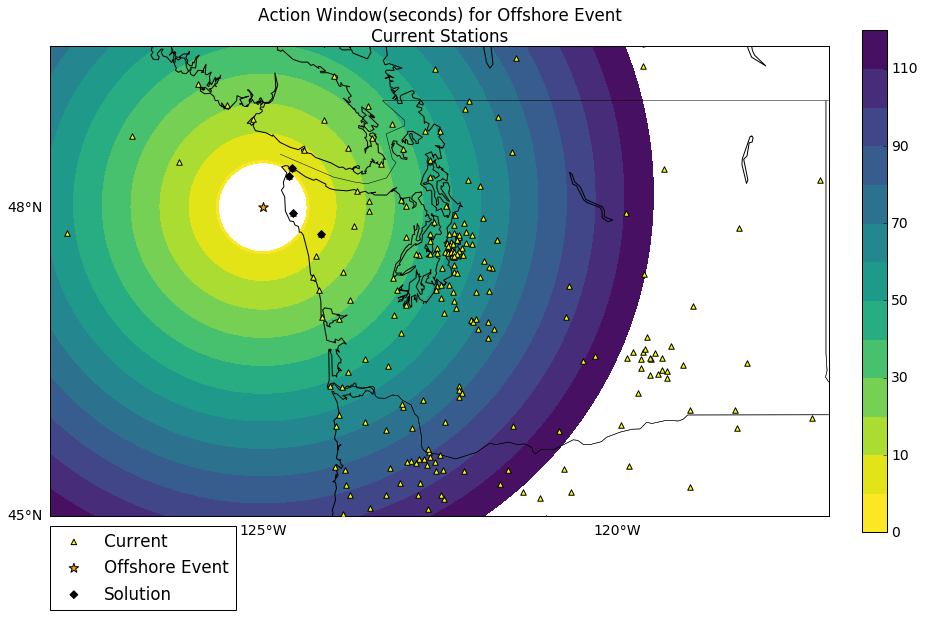

In [374]:
%run -i scripts/plot_heatmap.py \
--path=$grid_offshore_alert_path \
--title1="Action Window(seconds) for Offshore Event" \
--title2="Current Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

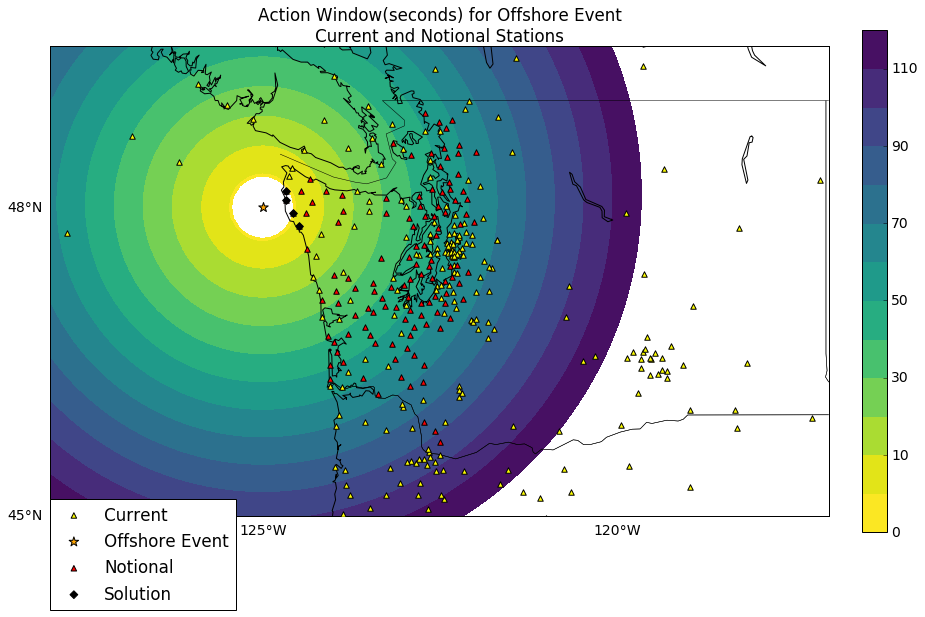

In [375]:
%run -i scripts/plot_heatmap.py \
--path=$grid_offshore_n_alert_path \
--title1="Action Window(seconds) for Offshore Event" \
--title2="Current and Notional Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

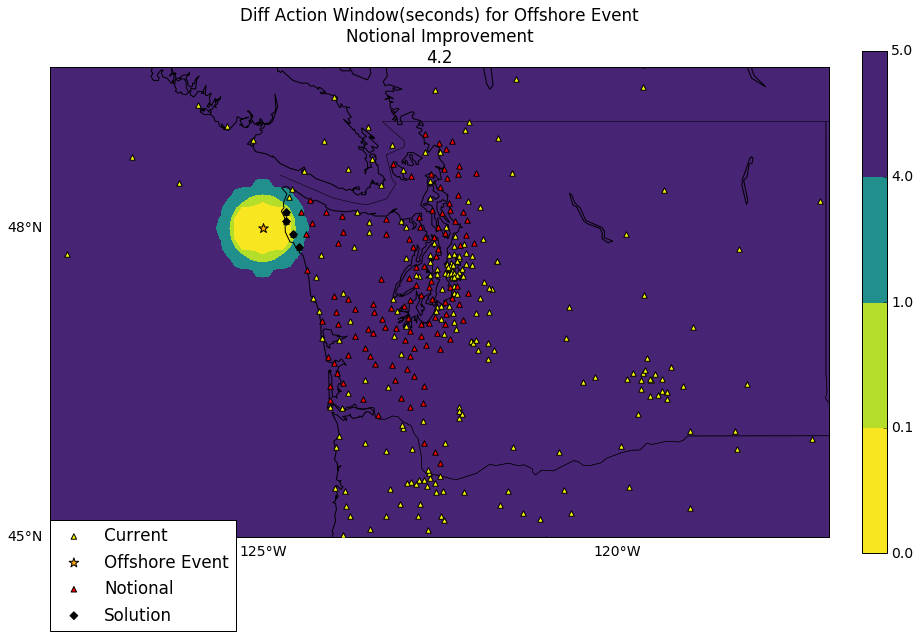

In [376]:
%run -i scripts/plot_heatmap.py \
--path=$grid_diff_offshore_alert_path \
--title1="Diff Action Window(seconds) for Offshore Event" \
--title2="Notional Improvement" \
--title3=$delta_trigger \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,0.1,1,4,5

### Action Window for  Aberdeen event

In [347]:
aberdeen_lat=47.0
aberdeen_lon=-124.0
aberdeen_depth = 55.0

#contour around event
%run -i scripts/make_grids.py \
--name=aberdeen \
--grid_types=dist_max \
--lat_min=$lat_min \
--lat_max=$lat_max \
--lon_min=$lon_min \
--lon_max=$lon_max \
--resolution=$resolution \
--num_solutions=$num_solutions

Profiling spatially...
Created the following grids:
/Users/joncon/Sites/magd_client/scripts/../pickle_jar/aberdeen/dist_max_grid/85x150-res-0.1.pickle


In [348]:
#contour aberdeen event
grid_aberdeen_event_path = "./pickle_jar/aberdeen/dist_max_grid/85x150-res-0.1.pickle"
grid_aberdeen_event = get_pickle(grid_aberdeen_event_path)

In [377]:
#create a single origin, then find nth closest current station distance
%run -i scripts/make_grids.py \
--name=washington_current \
--grid_types=dist_max \
--lat_min=$aberdeen_lat \
--lat_max=$aberdeen_lat  \
--lon_min=$aberdeen_lon  \
--lon_max=$aberdeen_lon \
--resolution=0.1 \
--num_solutions=$num_solutions

Profiling spatially...
Created the following grids:
/Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current/dist_max_grid/1x1-res-0.1.pickle


In [378]:
#distnace from event to 4th current station. matrix is 1x1
distance_aberdeen_path = "./pickle_jar/washington_current/dist_max_grid/1x1-res-0.1.pickle"
distance_aberdeen = get_pickle(distance_aberdeen_path)

In [379]:
#create a single origin, then find nth closest station distance
%run -i scripts/make_grids.py \
--name=washington_current_and_notional \
--grid_types=dist_max \
--lat_min=$aberdeen_lat \
--lat_max=$aberdeen_lat  \
--lon_min=$aberdeen_lon  \
--lon_max=$aberdeen_lon \
--resolution=0.1 \
--num_solutions=$num_solutions

Profiling spatially...
Created the following grids:
/Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current_and_notional/dist_max_grid/1x1-res-0.1.pickle


In [380]:
distance_aberdeen_n_path = "./pickle_jar/washington_current_and_notional/dist_max_grid/1x1-res-0.1.pickle"
distance_aberdeen_n = get_pickle(distance_aberdeen_n_path)

In [381]:
velocity_p = 5.4
velocity_s = 3
processing_time = 4

##############################################################
#aberdeen event
###############################################################
aberdeen_depth = 20

print("Distance to 4th station with current stations:")
print(distance_aberdeen.matrix[0][0])

print("Distance to 4th station with current and notional stations:")
print(distance_aberdeen_n.matrix[0][0])

station_markers = distance_aberdeen.markers


#from distance path, find trigger time. Use this time for every point in eq contour map
travel_current=distance_aberdeen.copy("travel_time", "aberdeen20")
travel_current.transform_to_trigger_time(velocity_p, processing_time, aberdeen_depth)
travel_current.save()

#trigger time (seconds)
trigger_time= travel_current.matrix[0][0]
print("aberdeen trigger time")
print(trigger_time)

#subtract contour grid from this value
grid_aberdeen_alert = grid_aberdeen_event.copy("event_warning", "aberdeen20")
grid_aberdeen_alert.markers =  {**station_markers, **grid_aberdeen_alert.markers}
grid_aberdeen_alert.firstn_solutions =distance_aberdeen.firstn_solutions
grid_aberdeen_alert.transform_to_s_travel_time(velocity_s, aberdeen_depth)
grid_aberdeen_alert.matrix =  grid_aberdeen_alert.matrix -trigger_time 
grid_aberdeen_alert.matrix.clip(0)
grid_aberdeen_alert.save()
grid_aberdeen_alert_path = grid_aberdeen_alert.get_path()


#distance from event to 4th current notional station. matrix is 1x1


station_n_markers = distance_aberdeen_n.markers

#from distance path, find trigger time. Use this time for every point in eq contour map
travel_notional=distance_aberdeen_n.copy("travel_time", "aberdeen_n20")
travel_notional.transform_to_trigger_time(velocity_p, processing_time, aberdeen_depth)
travel_notional.save()

#trigger time (seconds)
trigger_time_n = travel_notional.matrix[0][0]
print("aberdeen trigger time")
print(trigger_time_n)
delta_trigger = (trigger_time - trigger_time_n).round(2)
print("delta trigger time:")
print(delta_trigger)
delta_string= "Notional Improvement: {}".format(delta_trigger) 

#subtract contour grid from this value
grid_aberdeen_n_alert = grid_aberdeen_event.copy("event_warning", "aberdeen20_notional")
grid_aberdeen_n_alert.markers =  {**station_n_markers, **grid_aberdeen_n_alert.markers}
grid_aberdeen_n_alert.firstn_solutions = distance_aberdeen_n.firstn_solutions
grid_aberdeen_n_alert.transform_to_s_travel_time(velocity_s, aberdeen_depth)
grid_aberdeen_n_alert.matrix =  grid_aberdeen_n_alert.matrix -trigger_time_n 
grid_aberdeen_n_alert.matrix.clip(0)
grid_aberdeen_n_alert.save()
grid_aberdeen_n_alert_path = grid_aberdeen_n_alert.get_path()

#diff the two

grid_diff_aberdeen_alert = grid_aberdeen_n_alert.copy("event_warning_diff", "diff_aberdeen20")
print(grid_aberdeen_n_alert.matrix[0][0:5])
print(grid_aberdeen_alert.matrix[0][0:5])
grid_diff_aberdeen_alert.matrix =  grid_aberdeen_n_alert.matrix.clip(0) - grid_aberdeen_alert.matrix.clip(0)
print(grid_diff_aberdeen_alert.matrix[0][0:5])

# grid_diff_aberdeen_alert.matrix.clip(0)
grid_diff_aberdeen_alert.save()
grid_diff_aberdeen_alert_path = grid_diff_aberdeen_alert.get_path()

Distance to 4th station with current stations:
27.8279942952
Distance to 4th station with current and notional stations:
17.8555394454
aberdeen trigger time
10.346200019
aberdeen trigger time
8.96496742581
delta trigger time:
1.38
[ 207.14282756  205.24806651  203.36861004  201.50487106  199.6572737 ]
[ 205.76159497  203.86683392  201.98737745  200.12363847  198.27604111]
[ 1.38123259  1.38123259  1.38123259  1.38123259  1.38123259]


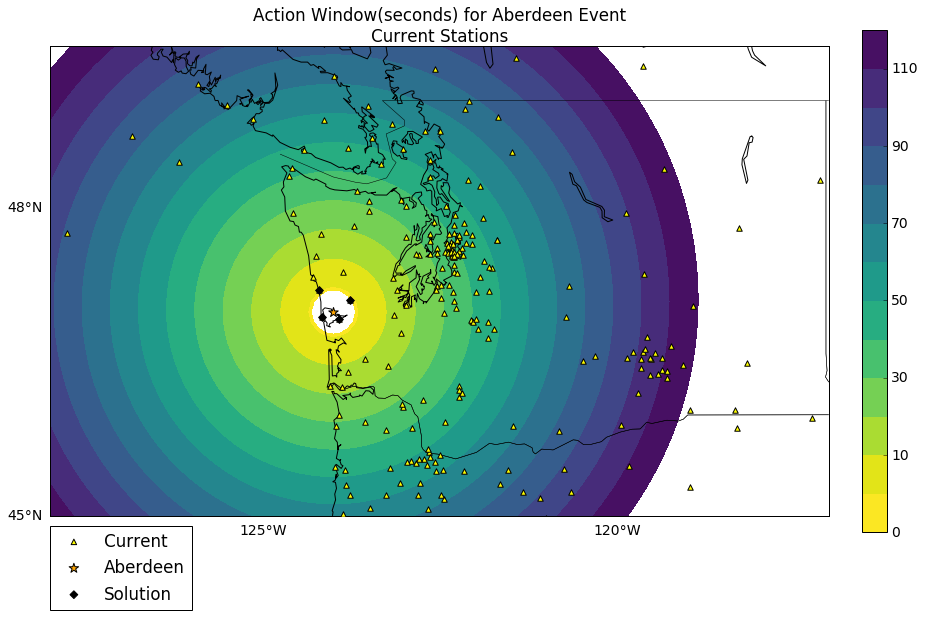

In [354]:
%run -i scripts/plot_heatmap.py \
--path=$grid_aberdeen_alert_path \
--title1="Action Window(seconds) for Aberdeen Event" \
--title2="Current Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

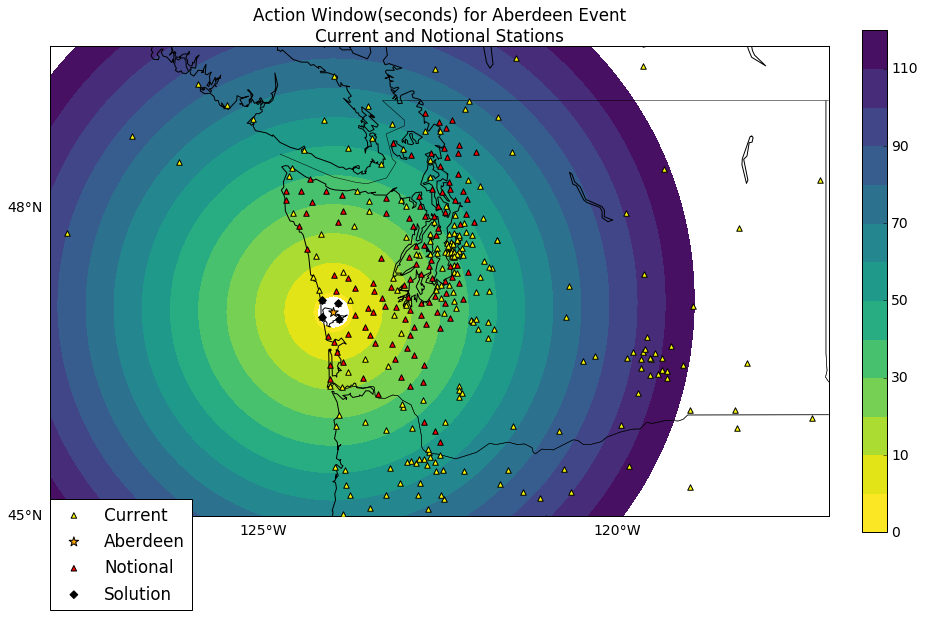

In [355]:
%run -i scripts/plot_heatmap.py \
--path=$grid_aberdeen_n_alert_path \
--title1="Action Window(seconds) for Aberdeen Event" \
--title2="Current and Notional Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

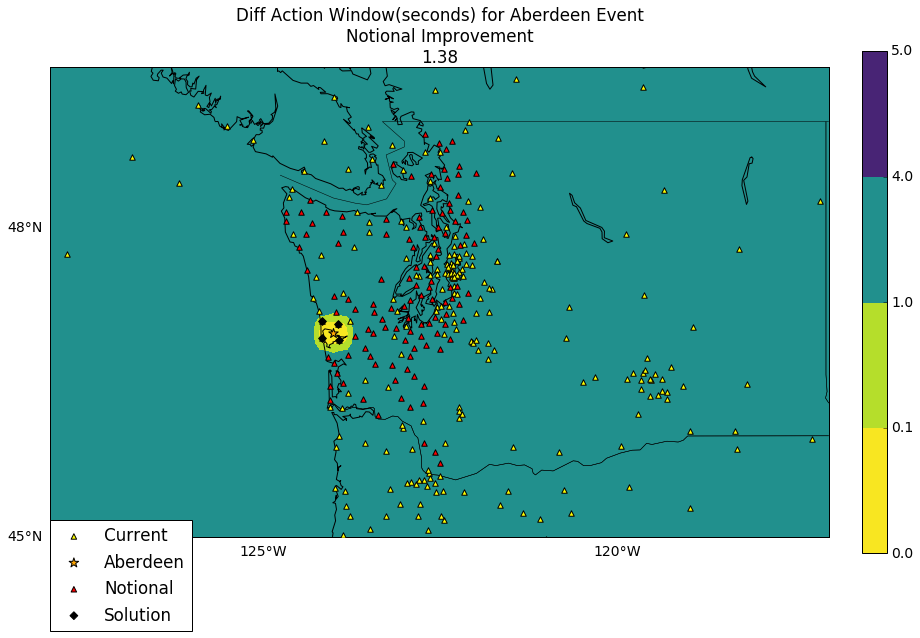

In [356]:
%run -i scripts/plot_heatmap.py \
--path=$grid_diff_aberdeen_alert_path \
--title1="Diff Action Window(seconds) for Aberdeen Event" \
--title2="Notional Improvement" \
--title3=$delta_trigger \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,0.1,1,4,5

### Action Window for  Mt. Buckner event

In [382]:
buckner_lat=48.5
buckner_lon=-121.0
buckner_depth = 55.0

#contour around event
%run -i scripts/make_grids.py \
--name=buckner \
--grid_types=dist_max \
--lat_min=$lat_min \
--lat_max=$lat_max \
--lon_min=$lon_min \
--lon_max=$lon_max \
--resolution=$resolution \
--num_solutions=$num_solutions

Profiling spatially...
Created the following grids:
/Users/joncon/Sites/magd_client/scripts/../pickle_jar/buckner/dist_max_grid/85x150-res-0.1.pickle


In [384]:
#contour buckner event
grid_buckner_event_path = "./pickle_jar/buckner/dist_max_grid/85x150-res-0.1.pickle"
grid_buckner_event = get_pickle(grid_buckner_event_path)

In [385]:
#create a single origin, then find nth closest current station distance
%run -i scripts/make_grids.py \
--name=washington_current \
--grid_types=dist_max \
--lat_min=$buckner_lat \
--lat_max=$buckner_lat  \
--lon_min=$buckner_lon  \
--lon_max=$buckner_lon \
--resolution=0.1 \
--num_solutions=$num_solutions

Profiling spatially...
Created the following grids:
/Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current/dist_max_grid/1x1-res-0.1.pickle


In [386]:
#distnace from event to 4th current station. matrix is 1x1
distance_buckner_path = "./pickle_jar/washington_current/dist_max_grid/1x1-res-0.1.pickle"
distance_buckner = get_pickle(distance_buckner_path)

In [387]:
#create a single origin, then find nth closest station distance
%run -i scripts/make_grids.py \
--name=washington_current_and_notional \
--grid_types=dist_max \
--lat_min=$buckner_lat \
--lat_max=$buckner_lat  \
--lon_min=$buckner_lon  \
--lon_max=$buckner_lon \
--resolution=0.1 \
--num_solutions=$num_solutions

Profiling spatially...
Created the following grids:
/Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current_and_notional/dist_max_grid/1x1-res-0.1.pickle


In [388]:
distance_buckner_n_path = "./pickle_jar/washington_current_and_notional/dist_max_grid/1x1-res-0.1.pickle"
distance_buckner_n = get_pickle(distance_buckner_n_path)

In [389]:
velocity_p = 5.4
velocity_s = 3
processing_time = 4

##############################################################
#buckner event
###############################################################
buckner_depth = 20

print("Distance to 4th station with current stations:")
print(distance_buckner.matrix[0][0])

print("Distance to 4th station with current and notional stations:")
print(distance_buckner_n.matrix[0][0])

station_markers = distance_buckner.markers


#from distance path, find trigger time. Use this time for every point in eq contour map
travel_current=distance_buckner.copy("travel_time", "buckner20")
travel_current.transform_to_trigger_time(velocity_p, processing_time, buckner_depth)
travel_current.save()

#trigger time (seconds)
trigger_time= travel_current.matrix[0][0]
print("buckner trigger time")
print(trigger_time)

#subtract contour grid from this value
grid_buckner_alert = grid_buckner_event.copy("event_warning", "buckner20")
grid_buckner_alert.markers =  {**station_markers, **grid_buckner_alert.markers}
grid_buckner_alert.firstn_solutions =distance_buckner.firstn_solutions
grid_buckner_alert.transform_to_s_travel_time(velocity_s, buckner_depth)
grid_buckner_alert.matrix =  grid_buckner_alert.matrix -trigger_time 
grid_buckner_alert.matrix.clip(0)
grid_buckner_alert.save()
grid_buckner_alert_path = grid_buckner_alert.get_path()


#distance from event to 4th current notional station. matrix is 1x1


station_n_markers = distance_buckner_n.markers

#from distance path, find trigger time. Use this time for every point in eq contour map
travel_notional=distance_buckner_n.copy("travel_time", "buckner_n20")
travel_notional.transform_to_trigger_time(velocity_p, processing_time, buckner_depth)
travel_notional.save()

#trigger time (seconds)
trigger_time_n = travel_notional.matrix[0][0]
print("buckner trigger time")
print(trigger_time_n)
delta_trigger = (trigger_time - trigger_time_n).round(2)
print("delta trigger time:")
print(delta_trigger)
delta_string= "Notional Improvement: {}".format(delta_trigger) 

#subtract contour grid from this value
grid_buckner_n_alert = grid_buckner_event.copy("event_warning", "buckner20_notional")
grid_buckner_n_alert.markers =  {**station_n_markers, **grid_buckner_n_alert.markers}
grid_buckner_n_alert.firstn_solutions = distance_buckner_n.firstn_solutions
grid_buckner_n_alert.transform_to_s_travel_time(velocity_s, buckner_depth)
grid_buckner_n_alert.matrix =  grid_buckner_n_alert.matrix -trigger_time_n 
grid_buckner_n_alert.matrix.clip(0)
grid_buckner_n_alert.save()
grid_buckner_n_alert_path = grid_buckner_n_alert.get_path()

#diff the two

grid_diff_buckner_alert = grid_buckner_n_alert.copy("event_warning_diff", "diff_buckner20")
print(grid_buckner_n_alert.matrix[0][0:5])
print(grid_buckner_alert.matrix[0][0:5])
grid_diff_buckner_alert.matrix =  grid_buckner_n_alert.matrix.clip(0) - grid_buckner_alert.matrix.clip(0)
print(grid_diff_buckner_alert.matrix[0][0:5])

# grid_diff_buckner_alert.matrix.clip(0)
grid_diff_buckner_alert.save()
grid_diff_buckner_alert_path = grid_diff_buckner_alert.get_path()

Distance to 4th station with current stations:
27.8279942952
Distance to 4th station with current and notional stations:
17.8555394454
buckner trigger time
10.346200019
buckner trigger time
8.96496742581
delta trigger time:
1.38
[ 300.15441861  298.22185993  296.29877395  294.38534388  292.48175663]
[ 298.77318601  296.84062734  294.91754136  293.00411128  291.10052403]
[ 1.38123259  1.38123259  1.38123259  1.38123259  1.38123259]


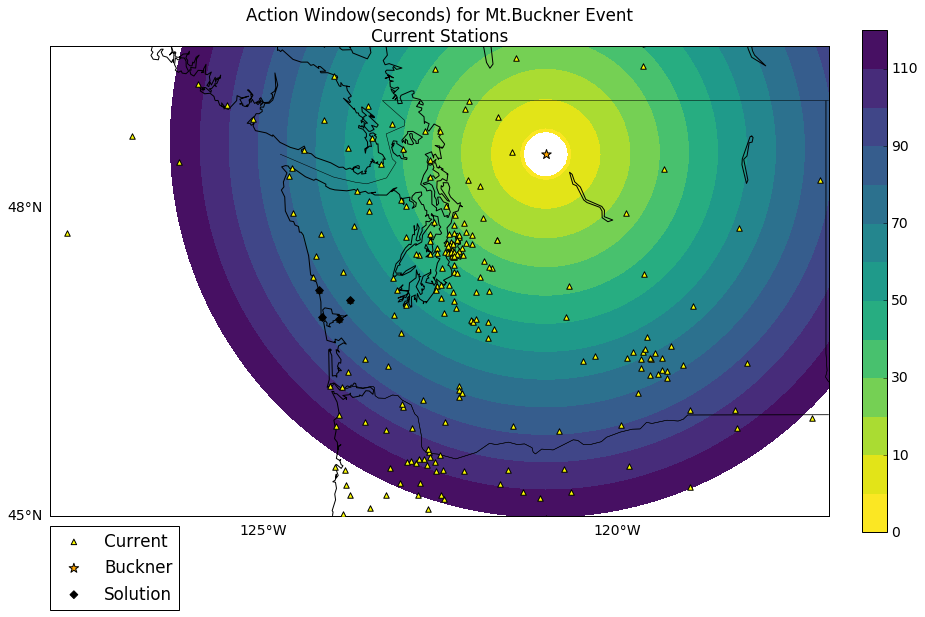

In [364]:
%run -i scripts/plot_heatmap.py \
--path=$grid_buckner_alert_path \
--title1="Action Window(seconds) for Mt.Buckner Event" \
--title2="Current Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

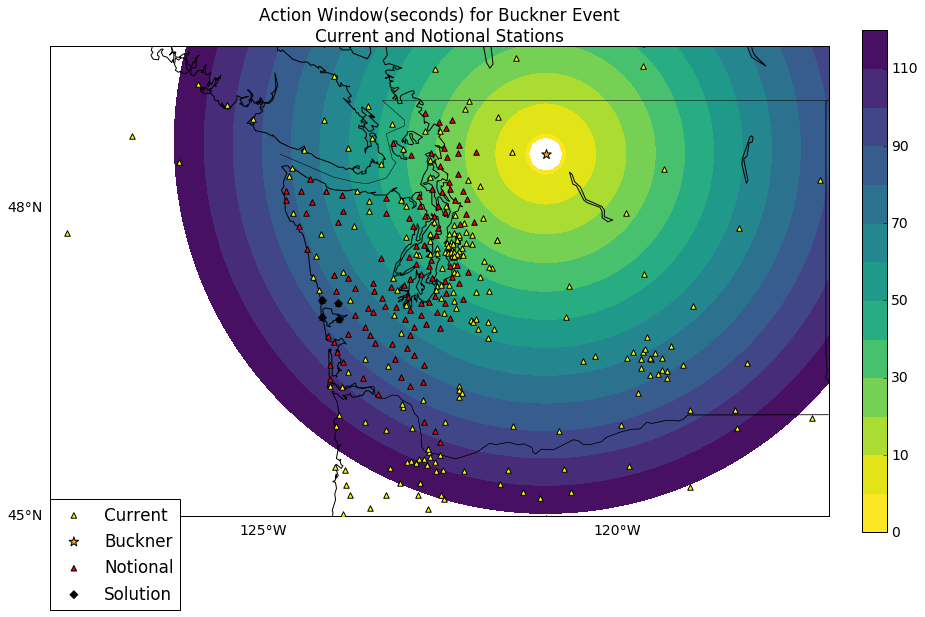

In [365]:
%run -i scripts/plot_heatmap.py \
--path=$grid_buckner_n_alert_path \
--title1="Action Window(seconds) for Buckner Event" \
--title2="Current and Notional Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

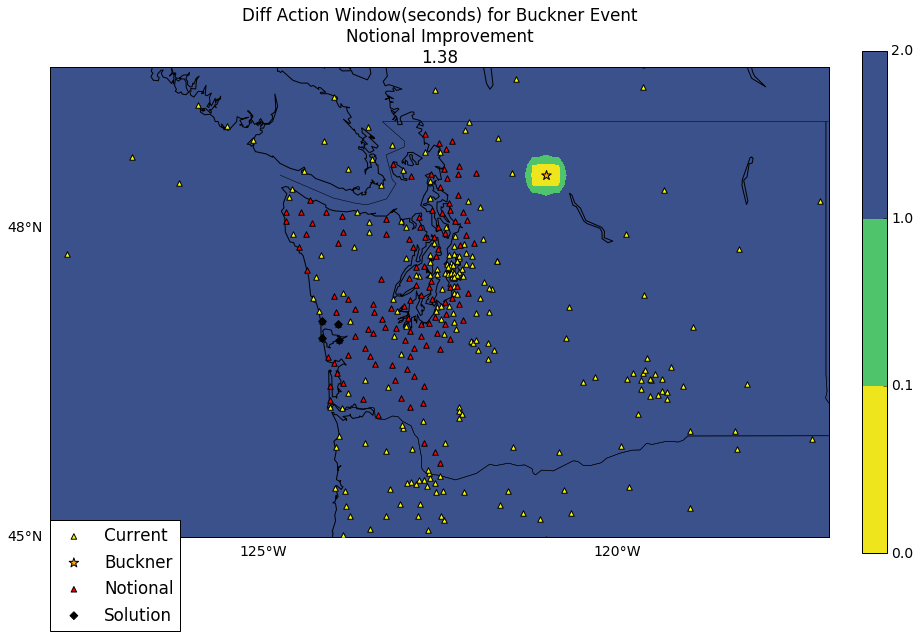

In [366]:
%run -i scripts/plot_heatmap.py \
--path=$grid_diff_buckner_alert_path \
--title1="Diff Action Window(seconds) for Buckner Event" \
--title2="Notional Improvement" \
--title3=$delta_trigger \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,0.1,1,2